## Import Packages

In [1]:
import plotly.graph_objs as pgo
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as pgo
import plotly.tools as tls

from mpl_toolkits.mplot3d import Axes3D

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



## Parse Data

In [2]:
# Parse training and test into data and labels
X_trO = pd.read_csv("trainEmployeeData.csv")
Y_tr = X_trO[['Attrition']]
X_tr = X_trO.drop(['Attrition','Unnamed: 0'], 1)
X_tr = X_tr.drop(['Over18'], axis=1)
X_tr = X_tr.drop(['EmployeeCount'], axis=1)
X_tr = X_tr.drop(['StandardHours'], axis=1)

X_testO = pd.read_csv("testEmployeeData.csv")
Y_test = X_testO[['Attrition', 'Unnamed: 0']]
X_test = X_testO.drop(['Attrition','Unnamed: 0'], 1)
X_test = X_test.drop(['Over18'], axis=1)
X_test = X_test.drop(['EmployeeCount'], axis=1)
X_test = X_test.drop(['StandardHours'], axis=1)

In [3]:
X_tr.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,42,Travel_Rarely,201,Research & Development,1,4,Life Sciences,517,2,Female,...,3,2,1,8,5,3,5,2,1,2
1,32,Travel_Rarely,128,Research & Development,2,1,Technical Degree,362,4,Male,...,3,4,0,9,5,3,6,2,0,4
2,48,Travel_Rarely,715,Research & Development,1,3,Life Sciences,1263,4,Male,...,3,3,0,25,3,4,1,0,0,0
3,51,Travel_Rarely,432,Research & Development,9,4,Life Sciences,116,4,Male,...,4,2,2,10,4,3,4,2,0,3
4,29,Travel_Rarely,726,Research & Development,29,1,Life Sciences,1859,4,Male,...,3,4,2,11,3,3,7,0,1,6


In [46]:
max(X_tr['JobInvolvement'])

4

In [4]:
Y_tr.head()

,Attrition
0,No
1,No
2,No
3,No
4,No


## Data Cleaning

In [5]:
# Check for any null values
total_data = pd.concat([X_trO,X_testO]).drop('Unnamed: 0', 1)
X_tr.isnull().any()

Age                         False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany              False
YearsInCurrentRole          False
YearsSinceLast

In [6]:
# We see no invalid data based off summary statistics
total_data.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.0,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,2,3,NaN,3,NaN,NaN,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1233,1043,NaN,961,NaN,NaN,606,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,802.485714,NaN,9.192517,2.912925,NaN,1.0,1024.865306,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,NaN,NaN,403.509100,NaN,8.106864,1.024165,NaN,0.0,602.024335,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,NaN,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,NaN,NaN,465.000000,NaN,2.000000,2.000000,NaN,1.0,491.250000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,NaN,NaN,802.000000,NaN,7.000000,3.000000,NaN,1.0,1020.500000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,NaN,NaN,1157.000000,NaN,14.000000,4.000000,NaN,1.0,1555.750000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


In [7]:
def transformXData(data):
    categorical = []
    for col, value in data.iteritems():
        if value.dtype == 'object':
            categorical.append(col)
    numerical = data.columns.difference(categorical)
    data_cat = data[categorical]
    data_cat = pd.get_dummies(data_cat)
    data_num = data[numerical]
    return pd.concat([data_num, data_cat], axis=1)

def transformYData(data):
    return data["Attrition"].apply(lambda x: 1 if x == "Yes" else 0)

tran_X_tr = transformXData(X_tr)
tran_X_test = transformXData(X_test)

tran_Y_tr = transformYData(Y_tr)
tran_Y_test = transformYData(Y_test)

tran_X_tr.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,42,201,1,4,517,2,95,3,1,1,...,0,0,0,0,0,1,0,0,1,0
1,32,128,2,1,362,4,84,2,2,1,...,0,0,0,0,0,0,0,1,1,0
2,48,715,1,3,1263,4,76,2,5,4,...,0,1,0,0,0,0,0,1,1,0
3,51,432,9,4,116,4,96,3,1,4,...,0,0,0,0,0,0,1,0,1,0
4,29,726,29,1,1859,4,93,1,2,3,...,0,0,0,0,0,1,0,0,1,0


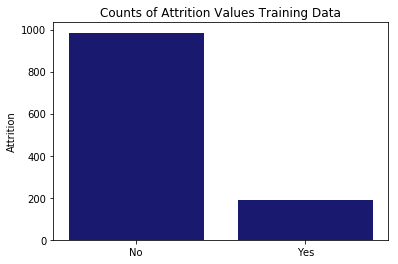

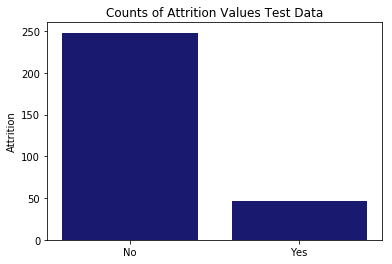

0    985
1    191
Name: Attrition, dtype: int64

In [37]:
no, yes = tran_Y_tr.value_counts()

no_test, yes_test = tran_Y_test.value_counts()


x = np.arange(2)
tr_vals = [no, yes]
test_vals = [no_test, yes_test]


fig, ax = pp.subplots()
pp.bar(x, tr_vals,color = 'midnightblue')
pp.xticks(x, ('No', 'Yes'))
pp.ylabel('Attrition')
pp.title('Counts of Attrition Values Training Data')
pp.savefig("data_viz/attrition_imbalance_train.png")
pp.show()

fig, ax = pp.subplots()
pp.bar(x, test_vals,color = 'midnightblue')
pp.xticks(x, ('No', 'Yes'))
pp.ylabel('Attrition')
pp.title('Counts of Attrition Values Test Data')
pp.savefig("data_viz/attrition_imbalance_test.png")
pp.show()

tran_Y_tr.value_counts()

## Balance Labels in Dataset

In [9]:
sm = SMOTE(random_state=0)
smote_tran_X_tr, smote_tran_Y_tr = sm.fit_sample(tran_X_tr,tran_Y_tr)

features_names = tran_X_tr.columns.values
smote_tran_X_tr_df = pd.DataFrame(smote_tran_X_tr)

In [10]:
smote_tran_X_tr_df.columns = np.ndarray.tolist(features_names)

In [11]:
smote_tran_X_tr_df.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,42.0,201.0,1.0,4.0,517.0,2.0,95.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,32.0,128.0,2.0,1.0,362.0,4.0,84.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,48.0,715.0,1.0,3.0,1263.0,4.0,76.0,2.0,5.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,51.0,432.0,9.0,4.0,116.0,4.0,96.0,3.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,29.0,726.0,29.0,1.0,1859.0,4.0,93.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [12]:
tran_X_tr.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,42,201,1,4,517,2,95,3,1,1,...,0,0,0,0,0,1,0,0,1,0
1,32,128,2,1,362,4,84,2,2,1,...,0,0,0,0,0,0,0,1,1,0
2,48,715,1,3,1263,4,76,2,5,4,...,0,1,0,0,0,0,0,1,1,0
3,51,432,9,4,116,4,96,3,1,4,...,0,0,0,0,0,0,1,0,1,0
4,29,726,29,1,1859,4,93,1,2,3,...,0,0,0,0,0,1,0,0,1,0


### Save augmented SMOTE training data

In [13]:
# np.savetxt('SMOTE_trainingX.csv', smote_tran_X_tr,delimiter=",")
# np.savetxt('SMOTE_trainingY.csv', smote_tran_Y_tr,delimiter=",")

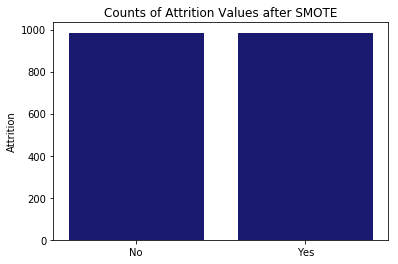

In [38]:
yes = np.count_nonzero(smote_tran_Y_tr == 1)
no = np.count_nonzero(smote_tran_Y_tr == 0)


x = np.arange(2)
money = [no, yes]


fig, ax = pp.subplots()
pp.bar(x, money,color = 'midnightblue')
pp.xticks(x, ('No', 'Yes'))
pp.ylabel('Attrition')
pp.title('Counts of Attrition Values after SMOTE')
pp.savefig("data_viz/SMOTE_balance_attrition.png")

pp.show()

## Random Forest Model

### Grid Search for Optimal Hyperparameter

In [15]:
param_grid = [
  {
      'n_estimators': [10, 20, 40, 80, 160], 
      'max_depth': [10, 20, 30, 40, 50, 55], 
      'max_features': ['sqrt', 'log2', 10]
  }
]

rfc = RandomForestClassifier(n_jobs=-1) 
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, verbose = 1)

CV_rfc.fit(tran_X_tr, tran_Y_tr)

opt_parameters = CV_rfc.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  2.5min finished


In [16]:
param_grid = [
  {
      'n_estimators': [10, 20, 40, 80, 160], 
      'max_depth': [10, 20, 30, 40, 50, 55], 
      'max_features': ['sqrt', 'log2', 10]
  }
]

sm_rfc = RandomForestClassifier(n_jobs=-1) 
CV_sm_rfc = GridSearchCV(estimator = sm_rfc, param_grid = param_grid, cv = 5, verbose = 1)

CV_sm_rfc.fit(smote_tran_X_tr, smote_tran_Y_tr)

sm_opt_parameters = CV_sm_rfc.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  2.6min finished


In [17]:
opt_parameters = {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20}

In [18]:
sm_opt_parameters = {'max_depth': 55, 'max_features': 'log2', 'n_estimators': 160}

In [19]:
# dir(CV_rfc)

In [20]:
pd.DataFrame(CV_sm_rfc.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{'max_depth': 10, 'n_estimators': 10, 'max_fea...",0.897970,"[0.659898477157, 0.967005076142, 0.94670050761..."
1,"{'max_depth': 10, 'n_estimators': 20, 'max_fea...",0.910660,"[0.662436548223, 0.97461928934, 0.967005076142..."
2,"{'max_depth': 10, 'n_estimators': 40, 'max_fea...",0.908122,"[0.652284263959, 0.97461928934, 0.972081218274..."
3,"{'max_depth': 10, 'n_estimators': 80, 'max_fea...",0.913198,"[0.675126903553, 0.97461928934, 0.969543147208..."
4,"{'max_depth': 10, 'n_estimators': 160, 'max_fe...",0.913706,"[0.675126903553, 0.972081218274, 0.97208121827..."
5,"{'max_depth': 10, 'n_estimators': 10, 'max_fea...",0.900508,"[0.639593908629, 0.964467005076, 0.96192893401..."
6,"{'max_depth': 10, 'n_estimators': 20, 'max_fea...",0.913198,"[0.682741116751, 0.964467005076, 0.96954314720..."
7,"{'max_depth': 10, 'n_estimators': 40, 'max_fea...",0.910152,"[0.667512690355, 0.972081218274, 0.97208121827..."
8,"{'max_depth': 10, 'n_estimators': 80, 'max_fea...",0.914721,"[0.654822335025, 0.979695431472, 0.97715736040..."
9,"{'max_depth': 10, 'n_estimators': 160, 'max_fe...",0.914213,"[0.662436548223, 0.979695431472, 0.97715736040..."


### Rerun RF Model on Optimal Parameters 

In [43]:
rfc = RandomForestClassifier(max_depth = opt_parameters["max_depth"]
                        ,max_features = opt_parameters['max_features']
                        ,n_estimators = opt_parameters['n_estimators']
                        ,n_jobs = -1)

rfc_fit = rfc.fit(tran_X_tr,tran_Y_tr)
rfc_preds = rfc_fit.predict(tran_X_test)

print("Training accuracy: ", rfc_fit.score(tran_X_tr, tran_Y_tr))
print("Test accuracy: ", rfc_fit.score(tran_X_test, tran_Y_test))
print("Recall Score: ", recall_score(tran_Y_test,rfc_preds))

Training accuracy:  0.979591836735
Test accuracy:  0.853741496599
Recall Score:  0.130434782609


In [42]:
sm_rfc = RandomForestClassifier(max_depth = sm_opt_parameters["max_depth"]
                        ,max_features = sm_opt_parameters['max_features']
                        ,n_estimators = sm_opt_parameters['n_estimators']
                        ,n_jobs = -1)

sm_rfc_fit = sm_rfc.fit(smote_tran_X_tr, smote_tran_Y_tr)
sm_rfc_fit_preds = sm_rfc_fit.predict(tran_X_test)


print("Training accuracy: ", sm_rfc_fit.score(smote_tran_X_tr, smote_tran_Y_tr))
print("Test accuracy: ", sm_rfc_fit.score(tran_X_test, tran_Y_test))
print("Recall Score: ", recall_score(tran_Y_test, sm_rfc_fit_preds))

Training accuracy:  1.0
Test accuracy:  0.863945578231
Recall Score:  0.217391304348


## Telescopic Search - Fine Grain Search

In [23]:
param_grid_fine = [
  {
      'n_estimators': [150, 155, 160,165], 
      'max_depth': [51, 52, 53, 54, 55], 
      'max_features': ['sqrt', 'log2',10]
  }
]

sm_rfc = RandomForestClassifier(n_jobs=-1) 
CV_sm_rfc_fine = GridSearchCV(estimator = sm_rfc, param_grid = param_grid_fine, cv = 5, verbose = 1)

CV_sm_rfc_fine.fit(smote_tran_X_tr, smote_tran_Y_tr)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [51, 52, 53, 54, 55], 'n_estimators': [150, 155, 160, 165], 'max_features': ['sqrt', 'log2', 10]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [24]:
sm_opt_parameters_fine = CV_sm_rfc_fine.best_params_
CV_sm_rfc_fine.best_params_

{'max_depth': 51, 'max_features': 'log2', 'n_estimators': 150}

In [25]:
sm_rfc_fine = RandomForestClassifier(max_depth = sm_opt_parameters_fine["max_depth"]
                        ,max_features = sm_opt_parameters_fine['max_features']
                        ,n_estimators = sm_opt_parameters_fine['n_estimators']
                        ,n_jobs = -1)

sm_rfc_fine_fit = sm_rfc_fine.fit(smote_tran_X_tr, smote_tran_Y_tr)
sm_rfc_fine_fit_preds = sm_rfc_fine_fit.predict(tran_X_test)


print("Training accuracy: ", sm_rfc_fine_fit.score(smote_tran_X_tr, smote_tran_Y_tr))
print("Test accuracy: ", sm_rfc_fine_fit.score(tran_X_test, tran_Y_test))
print("Recall Score: ", recall_score(tran_Y_test, sm_rfc_fine_fit_preds))

Training accuracy:  1.0
Test accuracy:  0.874149659864
Recall Score:  0.260869565217


In [26]:
pd.DataFrame(CV_sm_rfc_fine.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{'max_depth': 51, 'n_estimators': 150, 'max_fe...",0.918274,"[0.670050761421, 0.984771573604, 0.97969543147..."
1,"{'max_depth': 51, 'n_estimators': 155, 'max_fe...",0.913706,"[0.662436548223, 0.977157360406, 0.96954314720..."
2,"{'max_depth': 51, 'n_estimators': 160, 'max_fe...",0.914213,"[0.654822335025, 0.979695431472, 0.97969543147..."
3,"{'max_depth': 51, 'n_estimators': 165, 'max_fe...",0.915228,"[0.672588832487, 0.979695431472, 0.96954314720..."
4,"{'max_depth': 51, 'n_estimators': 150, 'max_fe...",0.921827,"[0.675126903553, 0.984771573604, 0.98223350253..."
5,"{'max_depth': 51, 'n_estimators': 155, 'max_fe...",0.915228,"[0.657360406091, 0.979695431472, 0.98223350253..."
6,"{'max_depth': 51, 'n_estimators': 160, 'max_fe...",0.913198,"[0.662436548223, 0.97461928934, 0.97461928934,..."
7,"{'max_depth': 51, 'n_estimators': 165, 'max_fe...",0.913198,"[0.644670050761, 0.984771573604, 0.97969543147..."
8,"{'max_depth': 51, 'n_estimators': 150, 'max_fe...",0.913706,"[0.670050761421, 0.977157360406, 0.96954314720..."
9,"{'max_depth': 51, 'n_estimators': 155, 'max_fe...",0.912183,"[0.672588832487, 0.969543147208, 0.96954314720..."


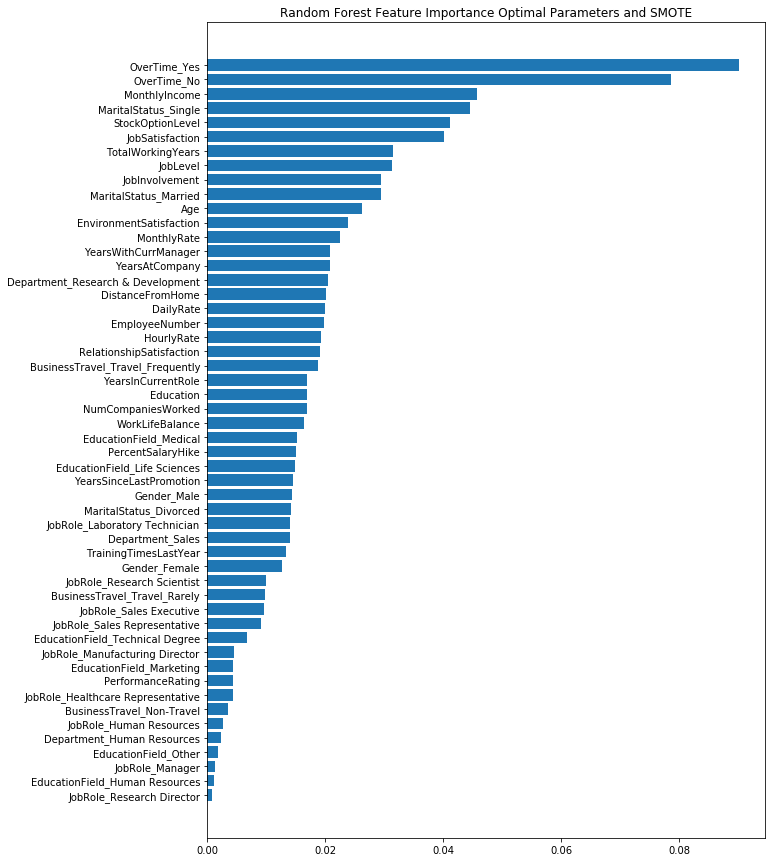

In [27]:
pp.figure(figsize = (10,15))
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    n = len(names)
    pp.barh(range(n), imp, align='center')
    pp.title("Random Forest Feature Importance Optimal Parameters and SMOTE")
    pp.yticks(range(len(names)), names)
    pp.savefig("data_viz/Fine_grain_ft_import_SMOTE.png")
    pp.show()

features_names = tran_X_tr.columns.values
f_importances(sm_rfc_fine.feature_importances_, features_names)

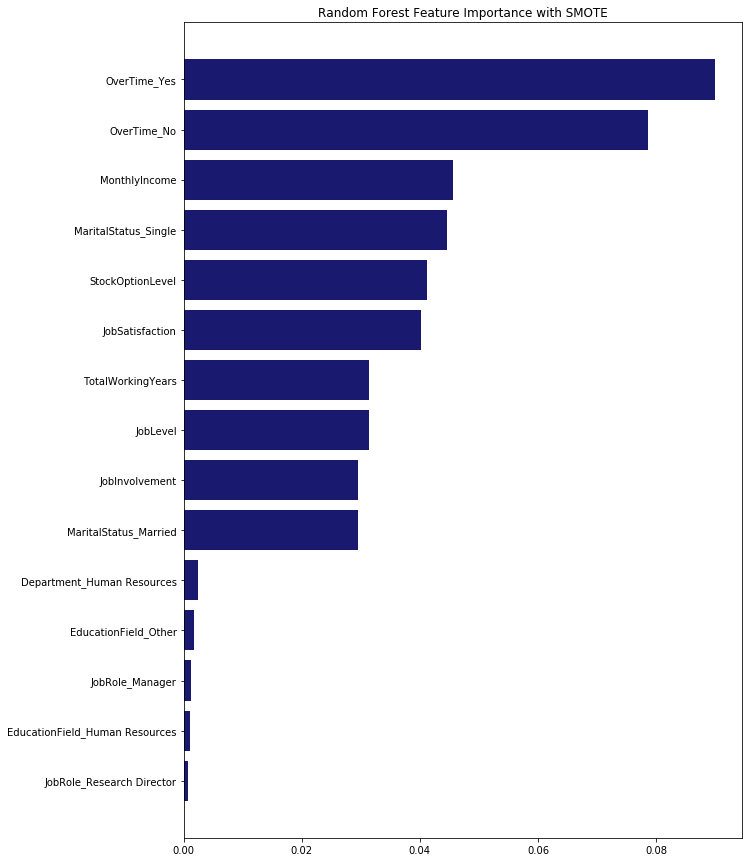

In [39]:
pp.figure(figsize = (10,15))
def f_importances_top15(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    low_5 = imp[:5]
    top_10 = imp[-10:]
    low_5n = names[:5]
    top_10n = names[-10:]
    imp = low_5 + top_10
    names=low_5n+top_10n
    n = len(names)
    pp.barh(range(n), imp, align='center',color = 'midnightblue')
    pp.title("Random Forest Feature Importance with SMOTE")
    pp.yticks(range(len(names)), names)
    pp.savefig("data_viz/Fine_grain_ft_import_SMOTE.png")
    pp.show()

features_names = tran_X_tr.columns.values
f_importances_top15(sm_rfc_fine.feature_importances_, features_names)
pp.savefig("data_viz/Fine_grain_ft_import_SMOTE.png")

In [29]:
for name, importance in zip(list(tran_X_tr.columns.values), sm_rfc_fine.feature_importances_):
    print(name, "=", importance)

Age = 0.0263133296518
DailyRate = 0.0199663030422
DistanceFromHome = 0.0200998573398
Education = 0.016954442015
EmployeeNumber = 0.0198479407875
EnvironmentSatisfaction = 0.0238343661136
HourlyRate = 0.0192771871972
JobInvolvement = 0.0295385695426
JobLevel = 0.0313588048338
JobSatisfaction = 0.040174062924
MonthlyIncome = 0.0456738301424
MonthlyRate = 0.0224486766478
NumCompaniesWorked = 0.0169512989436
PercentSalaryHike = 0.0150304898218
PerformanceRating = 0.00435828815437
RelationshipSatisfaction = 0.0191470069062
StockOptionLevel = 0.0412029222687
TotalWorkingYears = 0.0314216137128
TrainingTimesLastYear = 0.0133932105631
WorkLifeBalance = 0.0163569116216
YearsAtCompany = 0.0207649866717
YearsInCurrentRole = 0.0169947776188
YearsSinceLastPromotion = 0.0146074557024
YearsWithCurrManager = 0.0208008219711
BusinessTravel_Non-Travel = 0.00356047244937
BusinessTravel_Travel_Frequently = 0.0187595859017
BusinessTravel_Travel_Rarely = 0.00979040996194
Department_Human Resources = 0.00235

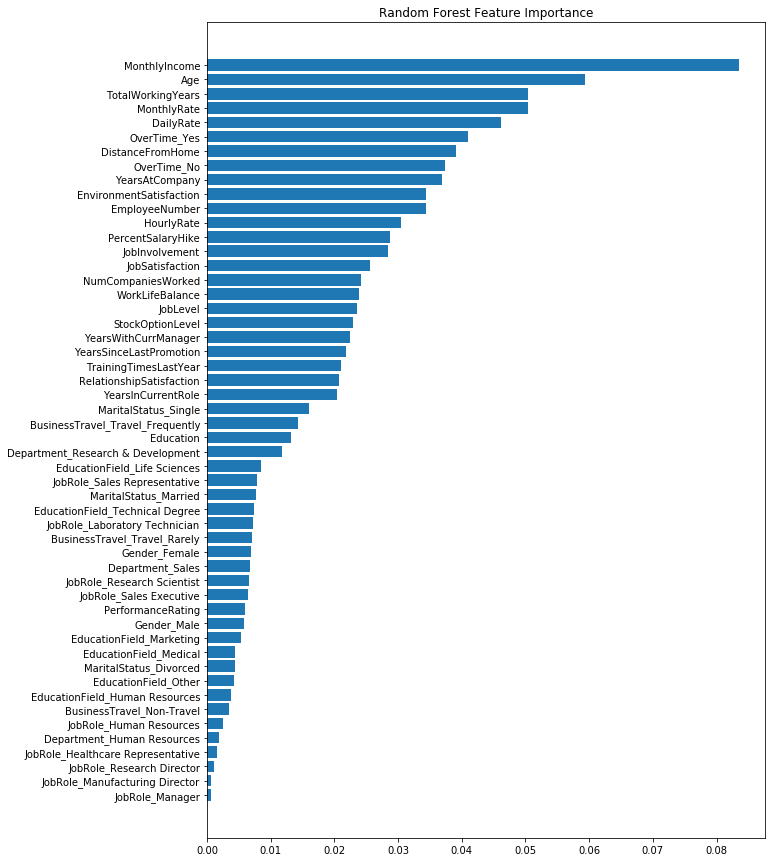

In [30]:
pp.figure(figsize = (10,15))
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    n = len(names)
    pp.title("Random Forest Feature Importance")
    pp.barh(range(n), imp, align='center')
    pp.yticks(range(len(names)), names)
    pp.savefig("data_viz/ft_import.png")
    pp.show()

features_names = tran_X_tr.columns.values
f_importances(rfc.feature_importances_, features_names)

In [31]:
for name, importance in zip(list(tran_X_tr.columns.values), rfc.feature_importances_):
    print(name, "=", importance)

Age = 0.0592817711223
DailyRate = 0.046196261718
DistanceFromHome = 0.0390199855782
Education = 0.0131857938892
EmployeeNumber = 0.034330955808
EnvironmentSatisfaction = 0.0344488609424
HourlyRate = 0.0304753495406
JobInvolvement = 0.0283796878877
JobLevel = 0.0235367962961
JobSatisfaction = 0.0256480251842
MonthlyIncome = 0.0834495553223
MonthlyRate = 0.0503502659269
NumCompaniesWorked = 0.0241468638548
PercentSalaryHike = 0.0287035694491
PerformanceRating = 0.00592495577264
RelationshipSatisfaction = 0.0207407393377
StockOptionLevel = 0.0228825787059
TotalWorkingYears = 0.0504400668024
TrainingTimesLastYear = 0.0210431791953
WorkLifeBalance = 0.0238206221621
YearsAtCompany = 0.0368760758953
YearsInCurrentRole = 0.0204650583426
YearsSinceLastPromotion = 0.021766455466
YearsWithCurrManager = 0.0225139056046
BusinessTravel_Non-Travel = 0.00351786003414
BusinessTravel_Travel_Frequently = 0.0142644516817
BusinessTravel_Travel_Rarely = 0.00711300445321
Department_Human Resources = 0.001889

In [32]:
# Scatter plot 
trace = pgo.Scatter(
    y = sm_rfc_fine.feature_importances_,
    x = features_names,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 11,
        color = sm_rfc_fine.feature_importances_,
        colorscale='Viridis',
        showscale=True
    ),
    text = features_names
)
data = [trace]

layout = pgo.Layout(
    autosize= True,
    title= 'Feature Importance of Random Forest with SMOTE',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    margin=pgo.Margin(
        l=50,
        r=50,
        b=250,
        t=100,
        pad=0
    ),
    yaxis=dict(
        title= 'Importance Score',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 3
    ),
    showlegend= False
)
fig = pgo.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')
